<a href="https://colab.research.google.com/github/joangog/object-detection/blob/main/mask_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model evaluation (inference) on mask dataset


Datasets:
*   MASKD (AICrowd)
*   Properly Wearing Masked Face Detection Dataset 

Models
*   YOLOv5n
*   YOLOv5s
*   YOLOv5m

**Note: GPU Runtime needed (hosted or local)**

*Example experiment: Tesla K80, 460.32.03, 11441 MiB, batch_size=1, num_workers=2*

In [ ]:
# Show system specs
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

### Initialization

In [2]:
# Parameters

dataset_name = 'PWMFD'  # Dataset to evaluate: 'MASKD' or 'PWMFD'

custom_results_file = None # Select None to generate results file name automatically from model info  

img_res = 320  # Image resolution (for YOLO models), try 608, 512, 416, 320 or 224
num_workers = 2  #  Data loader workers
batch_size = 1  # Data loader batch size  (imitate stream input)

th = 0.65  # Threshold for confidence score of predicted bboxes to show


# Directories

load_ckpt_path =  '/content/checkpoints/pretrained_optimized/PWMFD_yolov5s_mosaic_frozen10_sgd_ep50_lr01_trainres320_run/weights/best.pt'
model_info = load_ckpt_path.split('/')[-3].replace(dataset_name + '_', '').replace('run',f'infres{img_res}') + '_' +  load_ckpt_path.split('/')[-4]  # Get full model parameter info from weight folder name

import os
root_dir = os.getcwd()  # Root dir of project
dataset_dir = os.path.join(root_dir,f'dataset_{dataset_name}')

img_dir = os.path.join(dataset_dir,'images')
val_img_dir = os.path.join(img_dir,'val_images')

label_dir = os.path.join(dataset_dir,'labels')
val_label_dir = os.path.join(label_dir,'val_images')

ann_dir = os.path.join(dataset_dir,'annotations')

### Get requirements
*Note : Takes about 5 minutes or less. Restart runtime after installation if a problem arises.*

In [ ]:
# Clone asset files
!cd {root_dir}
!git clone https://github.com/joangog/object-detection-assets
!mv -n {os.path.join(root_dir,'object-detection-assets','scripts')} ./
!mv -n {os.path.join(root_dir,'object-detection-assets','config')} ./
!mv -n {os.path.join(root_dir,'object-detection-assets','checkpoints')} ./
!mv -n {os.path.join(root_dir,'object-detection-assets','samples')} ./
!mv -n {os.path.join(root_dir,'object-detection-assets','requirements.txt')} ./
!rm -rf {os.path.join(root_dir,'object-detection-assets')}


In [ ]:
# Install packages

import sys

if 'google.colab' in sys.modules:
  !pip install textwrap3 ptflops psutil imageio-ffmpeg git+https://github.com/googlecolab/colabtools.git
  !pip install --upgrade --no-cache-dir gdown
else:
  !cd {root_dir}
  !pip install -r requirements.txt

In [ ]:
# Install Yolov5
!cd {root_dir}
!git clone https://github.com/joangog/yolov5
!pip install -r {os.path.join(root_dir,'yolov5','requirements.txt')}

In [ ]:
# Install Yolov3
!cd {root_dir}
!git clone https://github.com/ultralytics/yolov3
!pip install -r {os.path.join(root_dir,'yolov3','requirements.txt')}

In [ ]:
# Install unrar command
if os.geteuid() != 0:  # If not root, ask for sudo priviledges
  from getpass import getpass
  password = getpass('Insert sudo password:')
  !echo {password} | sudo -S -k apt-get install unrar
else:
  !apt-get install unrar

### Import packages

In [11]:
from google.colab import files
from google.colab import drive
from google.colab.output import eval_js

import os, sys
import math
import time
import copy
import re
import io

import numpy as np
import pandas as pd
import json
import xml.etree.ElementTree as ET
import html

import PIL
import cv2
import IPython
from IPython.display import display, Javascript, Image, HTML
from base64 import b64decode, b64encode
import imageio
import matplotlib
import matplotlib.pyplot as plt

import torch
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.models.detection as M
import torchvision.transforms.functional as F
import torchvision.utils as U
from torchvision.datasets import CocoDetection

from pycocotools import coco
from pycocotools import mask as cocomask

from ptflops import get_model_complexity_info

import scripts.utils as SU
import scripts.transforms as ST
import scripts.engine as SE
import scripts.coco_utils as SCU
from scripts.coco_eval import CocoEvaluator
import scripts.js_utils as JSU

### (Optional) Connect to GDrive for storage access
*Note: Not possible with local runtime*

In [14]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Download Mask dataset

In [15]:
!cd {root_dir}
!mkdir -p dataset_{dataset_name}
!cd {dataset_dir}
!mkdir -p {img_dir} {ann_dir} {label_dir}
!cd {img_dir}
!mkdir {val_img_dir}
!cd {label_dir}
!mkdir {val_label_dir}

In [ ]:
if dataset_name == 'MASKD':

  !cd {root_dir}

  # Download validation images
  if not os.path.exists('val_images.zip'):
    !gdown --id '101F2k6PJ-tD_uwlsCG7zzGF9ILJW01M1'
  !unzip -q -n 'val_images.zip' -d {img_dir}

  # Download validation annotations
  if not os.path.exists('val.json'):
    !gdown -O {os.path.join(ann_dir,'val.json')} --id '1YLV7-7vmiNdFI8Xpdx_jbhnxfgQRWrgF'

elif dataset_name == 'PWMFD':

  # Download validation images
  if not os.path.exists('val_images.rar'):
    !gdown -O 'val_images.rar' --id  1PuQuCPxcf6H1NsyDPOgtXICUAW4dXk9p --no-cookies
  !unrar e -idq -o- 'val_images.rar' -d {val_img_dir}

  # Convert annotation files from PASCAL VOC .xml to COCO .json (only for PWMFD dataset)
  
  label_ids = {'with_mask': 1, 'without_mask': 2, 'incorrect_mask': 3}  # BG class is 0

  ann_count = 0  # Annotation counter

  images = []
  categories = []
  annotations = []

  xml_files = os.listdir(val_img_dir)
  xml_files = [file for file in xml_files if '.xml' in file]

  # Categories
  for label in label_ids:
    categories.append(
        {
          'supercategory': 'none',
          'id': label_ids[label],
          'name': label
        }
    )

  for xml_file in xml_files:  # For each annotation file

    tree = ET.parse(os.path.join(val_img_dir,xml_file))
    root = tree.getroot()

    # Image
    file_name = root[0].text
    height = int(root[1][1].text)
    width = int(root[1][0].text)
    id = int(re.sub(r'^\D*0*', '', file_name).replace('.jpg',''))
    images.append(
        {
          'file_name': file_name,
          'height': height,
          'width': width,
          'id': id
        }
    )
    
    # Annotations
    if len(root) > 2:  # If annotations (object attribute) exist, they will be after the 1-index attribute in the XML
      for i in range(2,len(root)):
        category_id = label_ids[root[i][0].text]
        xmin = int(root[i][1][0].text)
        ymin = int(root[i][1][1].text)
        xmax = int(root[i][1][2].text)
        ymax = int(root[i][1][3].text)
        annotations.append(
            {
              'iscrowd': 0,
              'image_id': id,
              'bbox': [xmin, ymin, xmax-xmin, ymax-ymin],
              'area': (xmax-xmin) * (ymax-ymin),
              'category_id': category_id,
              'ignore': 0,
              'id': ann_count,
              'segmentation': []
            }
        )
        ann_count += 1

  coco_dict = {
  'info': {},
  'images': images,
  'categories': categories,
  'annotations': annotations,
  'licenses': []
  }

  with open(os.path.join(ann_dir,f'val.json'),'w') as outfile:
    json.dump(coco_dict, outfile, indent=3)


# Copy COCO annotations in images folder
!cp {os.path.join(ann_dir,'val.json')} {val_img_dir}

### (Only for YOLO models) Convert format of annotations from COCO to YOLO

In [ ]:
for type_images in ['val']:

    ann_path = os.path.join(ann_dir, type_images + ".json")
    dataset = coco.COCO(ann_path)
    img_ids = dataset.getImgIds()

    for img_id in img_ids:

      img_anns = dataset.loadAnns(dataset.getAnnIds([img_id]))
      img_data = dataset.loadImgs([img_id])[0]
      img_file = img_data['file_name']
      img_width = img_data['width']
      img_height = img_data['height']

      label_file = img_file.replace('.jpg','.txt')
      
      with open(os.path.join(label_dir, f'{type_images}_images', label_file), 'w') as outfile:
        for ann in img_anns:
          x_center = (ann['bbox'][0] + ann['bbox'][2]/2) / img_width  # convert x_min to x_center and normalize to [0,1]
          y_center = (ann['bbox'][1] + ann['bbox'][3]/2) / img_height  # convert y_min to y_center and normalize to [0,1]
          width = ann['bbox'][2] / img_width
          height = ann['bbox'][3] / img_height 
          outfile.write("{} {} {} {} {}\n".format(int(ann['category_id'])-1,x_center,y_center,width,height))   # Category ids must be 0-indexed


### Load Mask dataset

In [ ]:
val_ann_file = 'val.json'  # annotations
val_ann_path = os.path.join(val_img_dir,val_ann_file)  

# Define data transforms
transforms = ST.Compose([ST.ToTensor()])

# Create dataset
val_dataset = CocoDetection(val_img_dir, val_ann_path, transforms = transforms)

# Create data loader
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=SU.collate_fn)

# Get label names
if dataset_name == 'MASKD':
  label_ids = [1,2]
  label_names = ['mask', 'no_mask']
elif dataset_name == 'PWMFD':
  label_ids = [1,2,3]
  label_names = ['with_mask', 'without_mask', 'incorrect_mask']
labels = dict(zip(label_ids,label_names))  # Label dictionary with id-name as key-value
labels_inv = dict(zip(label_names,label_ids))  # Inverse label dictionary with name-id as key-value
label_colors = {1: (0,255,0), 2:(255,0,0), 3: (255,190,0)}

### (Optional) Get dataset resolution information

In [20]:
img_ids = val_dataset.coco.getImgIds()
img_x_arr = []
img_y_arr = []

for img_id in img_ids:
  img = PIL.Image.open(os.path.join(val_img_dir,val_dataset.coco.loadImgs([img_id])[0]['file_name']))
  img_tensor = F.convert_image_dtype(F.to_tensor(img),torch.uint8)
  img_shape = img_tensor.shape
  img_x_arr.append(img_shape[1])
  img_y_arr.append(img_shape[2])

img_x_median = np.median(img_x_arr)
img_y_median = np.median(img_y_arr)

img_x_max = np.max(img_x_arr)
img_y_max = np.max(img_y_arr)

img_x_min = np.min(img_x_arr)
img_y_min = np.min(img_y_arr)

print(f'Median resolution: {img_x_median,img_y_median}')
print(f'Maximum resolution: {img_x_max,img_y_max}')
print(f'Minimum resolution: {img_x_min,img_y_min}')

Median resolution: (580.0, 630.5)
Maximum resolution: (6720, 4480)
Minimum resolution: (127, 114)


### Load model

In [21]:
# Delete utils package to reload it (if loaded), because YOLOv3 and YOLOv5 have
# the same name for it and it causes error
try:
  sys.modules.pop('utils')
except:
  pass

# @markdown Model Selection { display-mode: 'form', run: 'auto' }
model_name = 'YOLOv5s' # @param ['YOLOv5m', 'YOLOv5s', 'YOLOv5n']

# @markdown *Note: If you get the error "Cache may be out of date, try 'force_reload=True'" then restart runtime.*

if model_name == 'SSD300 VGG16':
  model_id = 'ssd300_vgg16'
  model = M.ssd300_vgg16(pretrained=False, progress=True)
  model_img_size = (3,300,300)
elif model_name == 'SSDlite320 MobileNetV3-Large':
  model_id = 'ssdlite320_mobilenet_v3_large'
  model = M.ssdlite320_mobilenet_v3_large(pretrained=False, progress=True)
  model_img_size = (3,320,320)
elif model_name == 'Faster R-CNN ResNet-50 FPN':
  model_id = 'fasterrcnn_resnet50_fpn'
  model = M.fasterrcnn_resnet50_fpn(pretrained=False, progress=True)
  model_img_size = (3,800,800) # COCO's 640x640 in upscaled to the model's minimum 800x800
elif model_name == 'Faster R-CNN MobileNetV3-Large FPN':
  model_id = 'fasterrcnn_mobilenet_v3_large_fpn'
  model = M.fasterrcnn_mobilenet_v3_large_fpn(pretrained=False, progress=True)
  model_img_size = (3,800,800) 
elif model_name == 'Mask R-CNN ResNet-50 FPN':
  model_id = 'maskrcnn_resnet50_fpn'
  model = M.maskrcnn_resnet50_fpn(pretrained=False, progress=True)
  model_img_size = (3,800,800)
elif 'YOLOv5' in model_name:
  model_id = model_name.lower().replace('-','_')
  model = torch.hub.load(os.path.join(root_dir,'yolov5'), 'custom', path=load_ckpt_path, source='local', force_reload=True)
  model_img_size = (3,img_res,img_res)
elif 'YOLOv3' in model_name:
  model_id = model_name.lower().replace('-','_')
  model = torch.hub.load(os.path.join(root_dir,'yolov3'), 'custom', path=load_ckpt_path, source='local', force_reload=True)
  model_img_size = (3,img_res,img_res)

# Prepare model for dataset (for Fast R-CNN or Mask R-CNN)
if 'R-CNN' in model_name: 
  num_classes = len(val_dataset.coco.getCatIds()) + 1
  # Get the number of input features for the bbox predictor
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # Replace the pre-trained head with a new one
  model.roi_heads.box_predictor = M.faster_rcnn.FastRCNNPredictor(in_features, num_classes)  # includes background (0) class
  if 'Mask R-CNN' in model_name:
    # Get the number of input features for the segmentation max predictor
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # Replace the mask predictor with a new one
    model.roi_heads.mask_predictor = M.mask_rcnn.MaskRCNNPredictor(in_features_mask, hidden_layer,num_classes)

print('-------------------------------------------------------------------------------------------------------\n')

print(f'Loaded model: {model_name} ({model_info})')
model_params = round(sum([param.numel() for param in model.parameters()]) / 1000000, 1)
print(f'\t- Trainable Parameters: {model_params}M')
model_macs, _ = get_model_complexity_info(model, model_img_size, as_strings=False, 
                                          print_per_layer_stat=False, verbose=False)
model_gflops = round(2 * int(model_macs) / 1000000000, 1)
print(f'\t- GFLOPs: {model_gflops}')

-------------------------------------------------------------------------------------------------------

Loaded model: YOLOv5s (yolov5s_mosaic_frozen10_sgd_ep50_lr01_trainres320_infres320_pretrained_optimized)
	- Trainable Parameters: 7.0M
	- GFLOPs: 4.0


### (Optional) Test model on image sample
*Note: If you get the error "module 'PIL.TiffTags' has no attribute 'IFD'" then restart runtime.*


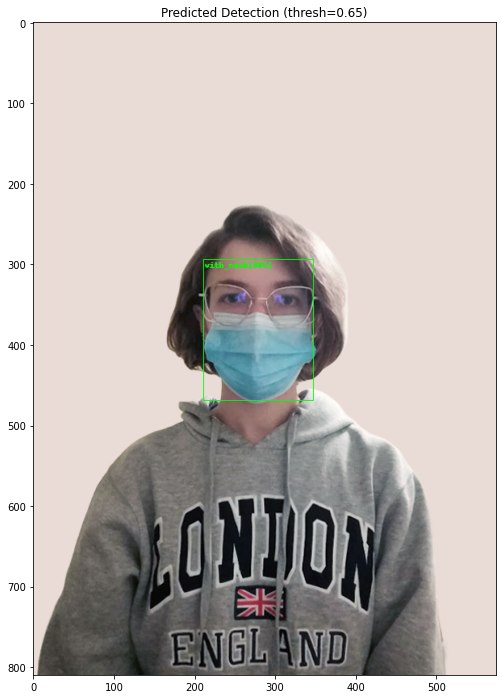

In [23]:
%matplotlib inline

# Parameters
img_from_path = True  # Select if image will be loaded from path or from id of image in dataset
img_path = 'samples/mask_full.png'  # Only for image from path
img_id = 1  # Only for image not from path (image from val dataset)

# Get appropriate device for model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Get image sample
if img_from_path:
  img = cv2.imread(img_path)
else:
  img = cv2.imread(os.path.join(val_img_dir,val_dataset.coco.loadImgs([img_id])[0]['file_name']))

# Format image
img = PIL.Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
img_tensor = F.convert_image_dtype(F.to_tensor(img),torch.uint8)
img_torchvision = torch.div(img_tensor,255).float().to(device)  # Format image for torchvision models
img_anns = val_dataset.coco.loadAnns(val_dataset.coco.getAnnIds([img_id]))

# Draw ground truth bboxes
if not img_from_path:  # If the image is not from path (if it is, ground truth doesn't exist)
  true_bboxes = SE.convert_to_xyxy(copy.deepcopy(F.Tensor([obj['bbox'] for obj in img_anns]).to(device)))  # Create deep copy to avoid updating original dataset
  true_labels = [labels[obj['category_id']] for obj in img_anns]
  true_img = U.draw_bounding_boxes(img_tensor, true_bboxes, true_labels, colors=[label_colors[obj['category_id']] for obj in img_anns])
  plt.figure(figsize = (12,12))
  plt.title('Ground Truth Detection')
  plot = plt.imshow(F.to_pil_image(true_img))

# Generate model predictions
model.eval()
with torch.no_grad():
  if 'YOLO' in model_name:
    pred = model([img], size=img_res)
  else:    
    pred = model([img_torchvision])

# Get predicted bboxes
# For YOLO models
if 'YOLO' in model_name:  
  pred_bboxes = []
  pred_label_ids = []
  pred_labels = []
  for bbox in pred.xyxy[0]:  # For every bbox
    conf = bbox[4]
    if conf > th:  # Show only bboxes with high confidence score
      pred_bboxes.append(bbox[:4])
      label_id = labels_inv[label_names[int(bbox[5])]]  # Convert YOLO label id to COCO label id
      pred_label_ids.append(label_id)  
      pred_labels.append(labels[label_id] + f'[{int(conf*100)}%]')
  if len(pred_bboxes) != 0:
    pred_bboxes = torch.stack(pred_bboxes)

# For torchvision models
else:
  for i, bbox in enumerate(pred[0]['boxes']):  # For every bbox
    conf = pred[0]['scores'][i]
    if conf > th:  # Show only bboxes with high confidence score
      pred_bboxes.append(bbox)
      label_id = pred[0]['labels'][i]
      pred_label_ids.append(label_id)
      pred_labels.append(labels[label_id] + f'[{int(conf*100)}%]')
  if len(pred_bboxes) != 0:
    pred_bboxes = torch.stack(pred_bboxes)

# Draw predicted bboxes
if len(pred_bboxes) != 0:
  pred_img = U.draw_bounding_boxes(img_tensor, pred_bboxes, pred_labels, colors=[label_colors[label_id] for label_id in pred_label_ids])
else:  # If no bboxes are found just return the image
  pred_img = img_tensor
plt.figure(figsize = (12,12))
plt.title(f'Predicted Detection (thresh={th})')
plot = plt.imshow(F.to_pil_image(pred_img))

### (Optional) Test model on saved video


In [26]:
# Parameters
video_path = 'samples/mask_video.mp4'
resize = True  # Flag wether to resize video to model image resolution (img_res)

# Make detected video folder
video_name = video_path.split('/')[-1].split('.')[0]
detected_video_path = os.path.join(root_dir,video_name)
!mkdir {detected_video_path}

# Get appropriate device for model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Get video sample
video = cv2.VideoCapture(video_path)

# Get video resolution and fps
fps = video.get(cv2.CAP_PROP_FPS)
width  = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Get resized resolution
resize_scale = min(img_res/width,img_res/height)
resized_height = int(height*resize_scale)
resized_width = int(width*resize_scale)

frame_num = 0

# Process video
while(video.isOpened()):

    # Read frame
    ret, img = video.read()
    if img is None:  # If video ran out of frames, stop
      break  

    # Resize frame
    img = cv2.resize(img,(resized_width,resized_height),interpolation = cv2.INTER_AREA) if resize else img

    # Format frame
    img = PIL.Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    img_tensor = F.convert_image_dtype(F.to_tensor(img),torch.uint8)
    img_torchvision = torch.div(img_tensor,255).float().to(device)

    # Generate model predictions
    model.eval()
    with torch.no_grad():
      if 'YOLO' in model_name:
        pred = model([img], size=img_res)
      else:    
        pred = model([img_torchvision])

    # Get predicted bboxes
    # For YOLO models
    if 'YOLO' in model_name:  
      pred_bboxes = []
      pred_label_ids = []
      pred_labels = []
      for bbox in pred.xyxy[0]:  # For every bbox
        conf = bbox[4]
        if conf > th:  # Show only bboxes with high confidence score
          pred_bboxes.append(bbox[:4])
          label_id = labels_inv[label_names[int(bbox[5])]]  # Convert YOLO label id to COCO label id
          pred_label_ids.append(label_id)  
          pred_labels.append(labels[label_id] + f'[{int(conf*100)}%]')
      if len(pred_bboxes) != 0:
        pred_bboxes = torch.stack(pred_bboxes)

    # For torchvision models
    else:
      for i, bbox in enumerate(pred[0]['boxes']):  # For every bbox
        conf = pred[0]['scores'][i]
        if conf > th:  # Show only bboxes with high confidence score
          pred_bboxes.append(bbox)
          label_id = pred[0]['labels'][i]
          pred_label_ids.append(label_id)
          pred_labels.append(labels[label_id] + f'[{int(conf*100)}%]')
      if len(pred_bboxes) != 0:
        pred_bboxes = torch.stack(pred_bboxes)


    # Draw predicted bboxes
    if len(pred_bboxes) != 0:
      pred_img = U.draw_bounding_boxes(img_tensor, pred_bboxes, pred_labels, colors=[label_colors[label_id] for label_id in pred_label_ids])
    else:  # If no bboxes are found just return the image
      pred_img = img_tensor
   
    # Save frame
    F.to_pil_image(pred_img).save(os.path.join(detected_video_path,f'{frame_num}.png'))

    frame_num += 1

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()

# Generate video from predicted frames
frame_files = os.listdir(detected_video_path)
frame_files.sort(key=lambda x: int(x.replace('.png','')))  # Sort numerically
with imageio.get_writer('detection.mp4', fps=24) as writer:
    for frame_file in frame_files:
        writer.append_data(imageio.imread(os.path.join(detected_video_path,frame_file)))

# Show video
mp4 = open('detection.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=480 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

mkdir: cannot create directory ‘/content/mask_video’: File exists


### (Optional) Test model on webcam video stream
*Note: FPS can be affected by latency between webcam and colab. For accurate FPS it is possible to run YOLOv5 locally (not in Colab) using the detect.py script:*

*python detect.py --weights /path/ --source 0 --imgsz 320 --view-img --conf-thres 0.65*

In [ ]:
# Get appropriate device for model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Start streaming video from webcam
JSU.video_stream()

# FPS monitor
fps = 0

# Initialze bounding box to empty
bbox = ''
count = 0 

while True:
    
    js_reply = JSU.video_frame(fps, bbox)
    if not js_reply:
        break

    # Convert JS response to PIL Image
    frame = JSU.js_to_image(js_reply["img"])
    plt.imshow(frame)

    # Create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # Format frame (for torchvision models)
    frame_tensor = F.convert_image_dtype(F.to_tensor(frame),torch.uint8)
    frame_torchvision = torch.div(frame_tensor,255).float().to(device)

    # Generate model predictions
    model.eval()
    model_time = time.time()
    with torch.no_grad():
      if 'YOLO' in model_name:
        pred = model(frame, size=img_res)
      else:    
        pred = model([frame_torchvision])
    model_time = time.time() - model_time
    fps = int(1/model_time)

    # Get predicted bboxes
    # For YOLO models
    if 'YOLO' in model_name:  
      pred_bboxes = []
      pred_label_ids = []
      pred_labels = []
      for img in pred.xyxy: # For every image
        for bbox in img:  # For every bbox of that image
          conf = bbox[4]
          if conf > th:  # Show only bboxes with high confidence score
            pred_bboxes.append(bbox[:4])
            label_id = labels_inv[label_names[int(bbox[5])]]  # Convert YOLO label id to COCO label id
            pred_label_ids.append(label_id)  
            pred_labels.append(labels[label_id] + f'[{int(conf*100)}%]')
      if len(pred_bboxes) != 0:
        pred_bboxes = torch.stack(pred_bboxes)
    # For torchvision models
    else:
      for i, bbox in enumerate(pred[0]['boxes']):  # For every bbox
        conf = pred[0]['scores'][i]
        if conf > th:  # Show only bboxes with high confidence score
          pred_bboxes.append(bbox)
          label_id = pred[0]['labels'][i]
          pred_label_ids.append(label_id)
          pred_labels.append(labels[label_id] + f'[{int(conf*100)}%]')
      if len(pred_bboxes) != 0:
        pred_bboxes = torch.stack(pred_bboxes)  

    predictions = zip(pred_label_ids, pred_labels, pred_bboxes)

    # Loop through detections and draw them on transparent overlay image
    for label_id, label, bbox in predictions:
      left, top, right, bottom = bbox
      left = int(left); top = int(top); right = int(right); bottom = int(bottom)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), label_colors[label_id], 2)
      bbox_array = cv2.putText(bbox_array, "{}".format(label),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        label_colors[label_id], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = JSU.bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

### Evaluate model
*Note 1: If you get the error "module 'PIL.TiffTags' has no attribute 'IFD'" then restart runtime.*

*Note 2: To get accurate maximum GPU memory usage logging, restart runtime when choosing a different model.*

In [ ]:
# Get appropriate device for model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(f'Model: {model_name} ({model_info})')

# Evaluate model
evaluator, fps, max_mem, outputs = SE.evaluate(model, val_data_loader, device, img_size=img_res)

print(f'\nFPS: {fps}\n')

Model: YOLOv5s (yolov5s_mosaic_frozen10_sgd_ep50_lr01_trainres320_infres320_pretrained_optimized)
Test:  [   0/1820]  eta: 0:03:33  model_time: 0.0163 (0.0163)  evaluator_time: 0.0247 (0.0247)  time: 0.1173  data: 0.0578  max mem: 97
Test:  [ 100/1820]  eta: 0:01:17  model_time: 0.0133 (0.0146)  evaluator_time: 0.0210 (0.0213)  time: 0.0381  data: 0.0009  max mem: 97
Test:  [ 200/1820]  eta: 0:01:09  model_time: 0.0137 (0.0142)  evaluator_time: 0.0211 (0.0212)  time: 0.0418  data: 0.0012  max mem: 151
Test:  [ 300/1820]  eta: 0:01:04  model_time: 0.0137 (0.0141)  evaluator_time: 0.0214 (0.0213)  time: 0.0411  data: 0.0011  max mem: 151
Test:  [ 400/1820]  eta: 0:01:01  model_time: 0.0133 (0.0141)  evaluator_time: 0.0222 (0.0217)  time: 0.0412  data: 0.0010  max mem: 151
Test:  [ 500/1820]  eta: 0:00:57  model_time: 0.0141 (0.0141)  evaluator_time: 0.0231 (0.0218)  time: 0.0439  data: 0.0012  max mem: 168
Test:  [ 600/1820]  eta: 0:00:53  model_time: 0.0131 (0.0142)  evaluator_time: 0.0

### Save metric results

In [ ]:
cols = ['model', 'model_img_size', 'model_params', 'model_gflops', 'fps', 'max_mem', 'iou_type', 'metric', 'iou', 'area', 'max_dets', 'score']
model = []
model_img_size_arr = []
model_params_arr = []
model_gflops_arr = []
fps_arr = []
max_mem_arr = []
iou_type = []
metric = []
iou = []
area = []
max_dets = []
score = []

# Set column values
for curr_iou_type, coco_eval in evaluator.coco_eval.items():
  model += [model_info for i in range(0,12)]
  model_img_size_arr += [model_img_size[1] for i in range(0,12)]
  model_params_arr += [model_params for i in range(0,12)]
  model_gflops_arr += [model_gflops for i in range(0,12)]
  fps_arr += [fps for i in range(0,12)]
  max_mem_arr += [max_mem for i in range(0,12)]
  iou_type += [curr_iou_type for i in range(0,12)]
  metric += ['avg_precision' for i in range(0,6)] + ['avg_recall' for i in range(0,6)]
  iou += ['0.50:0.95', '0.50', '0.75'] + ['0.50:0.95' for i in range(0,9)]
  area += ['all' for i in range(0,3)] + ['small', 'medium', 'large'] + ['all' for i in range(0,3)] + ['small', 'medium', 'large'] 
  max_dets += [100 for i in range(0,6)] + [1, 10] + [100 for i in range(0,4)]
  score += list(coco_eval.stats)

results = pd.DataFrame(np.column_stack([model, model_img_size_arr, model_params_arr, model_gflops_arr, fps_arr, max_mem_arr, iou_type, metric, iou, area, max_dets, score]))
results.columns = cols

In [ ]:
# Save to file

results_dir = root_dir

gpu = torch.cuda.get_device_name(0).lower()  # Keep only short gpu name
for pattern in [' ', 'tesla', 'geforce', 'nvidia']:  
  gpu = gpu.replace(pattern,'')

if custom_results_file:
  results_file = custom_results_file
else:
  results_file = f'{dataset_name}_{gpu}_{model_info}_metrics.csv'
results_path = os.path.join(results_dir, results_file)

if os.path.exists(results_path):
      os.remove(results_path)
with open(results_path, 'w') as outfile: 
    results.to_csv(outfile)

### (Optional) Save results to GDrive

In [ ]:
# Save to GDrive
gdrive_results_dir = '/content/drive/MyDrive/object-detection-results'
!mkdir {gdrive_results_dir}
!mkdir {os.path.join(gdrive_results_dir,dataset_name)}
gdrive_results_path = os.path.join(gdrive_results_dir, dataset_name, results_file)
if os.path.exists(gdrive_results_path):
  os.remove(gdrive_results_path)
with open(gdrive_results_path, 'w') as outfile: 
  results.to_csv(outfile)

NameError: ignored